In [1]:
import jax
from functools import partial
from jax import grad, jacfwd, vmap, jit, hessian
from jax.lax import scan
from jax.ops import index_update, index
import jax.random as jnp_random
import jax.numpy as np
import random

import time

from jax.flatten_util import ravel_pytree

import numpy as onp
from opt_solver import AugmentedLagrangian
from dynamics import SingleIntegrator
from ergodic_metric import ErgodicMetric
from utils import BasisFunc, get_phik, get_ck
from target_distribution import TargetDistribution
from IPython.display import clear_output
import matplotlib.pyplot as plt

/Users/ia285/miniconda3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
class ErgodicTrajectoryOpt(object):
    def __init__(self, time_horizon=20) -> None:
        self.basis           = BasisFunc(n_basis=[10,10])
        self.erg_metric      = ErgodicMetric(self.basis)
        self.robot_model     = SingleIntegrator()
        n,m = self.robot_model.n, self.robot_model.m
        self.target_distr    = TargetDistribution()
        opt_args = {
            'x0' : np.array([0.1, 1.1]),
            'xf' : np.array([5, 1.0]),
            'phik' : get_phik(self.target_distr.evals, self.basis)
        }
        x = np.ones((time_horizon, self.robot_model.n)) * opt_args['x0']
        x = np.linspace(opt_args['x0'], opt_args['xf'], time_horizon, endpoint=True)
        u = np.zeros((time_horizon, self.robot_model.m))
        self.init_sol = np.concatenate([x, u], axis=1) 

        @vmap
        def emap(x):
            """ Function that maps states to workspace """
            return np.array([x[0]/5, x[1]/3])
        def barrier_cost(e):
            """ Barrier function to avoid robot going out of workspace """
            return (np.maximum(0, e-1) + np.maximum(0, -e))**2
        @jit
        def loss(z, args):
            """ Traj opt loss function, not the same as erg metric """
            x, u = z[:, :n], z[:, n:]
            phik = args['phik']
            xpast = args['xpast']
            x = np.vstack([xpast, x])
            e = emap(x)
            ck = get_ck(e, self.basis)
            return 20*self.erg_metric(ck, phik) \
                    + 0.1 * np.mean(u**2) \
                    + 100*np.mean(barrier_cost(e))

        def eq_constr(z, args):
            """ dynamic equality constriants """
            x, u = z[:, :n], z[:, n:]
            x0 = args['x0']
            xf = args['xf']
            return np.vstack([
                x[0]-x0, 
                x[1:,:]-vmap(self.robot_model.f)(x[:-1,:], u[:-1,:]),
                # x[-1] - xf
            ])

        def ineq_constr(z,args):
            """ control inequality constraints"""
            x, u = z[:, :n], z[:, n:]
            return np.concatenate([
                (np.abs(u) - 5.).flatten(),
                (-np.linalg.norm(x-np.array([2.5,1.0]), axis=1) + 0.75).flatten(),
                (-np.linalg.norm(x-np.array([4.5,1.0]), axis=1) + 0.5).flatten(),
                (-np.linalg.norm(x-np.array([1.0,1.0]), axis=1) + 0.5).flatten()
                ])

        self.solver = AugmentedLagrangian(
                                            self.init_sol,
                                            loss, 
                                            eq_constr, 
                                            ineq_constr, 
                                            opt_args, 
                                            step_size=0.01,
                                            c=1.0
                    )
        # self.solver.solve()


In [3]:
robot = SingleIntegrator()
traj_opt = ErgodicTrajectoryOpt()

In [4]:
# sol = traj_opt.solver.get_solution()
X, Y = traj_opt.target_distr.domain
P = traj_opt.target_distr.evals[0].reshape(X.shape)
# clear_output(wait=T'rue)
# plt.contour(X, Y, P)
# plt.scatter(sol['x'][:,0], sol['x'][:,1])
# # plt.xlim(0,1)
# # plt.ylim(0,1)
# # plt.axis('square')
# plt.show()

/var/folders/87/hlqv70yd0n79wj330vzqffx10y2fzc/T/ipykernel_7491/2180366561.py:31: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, P)


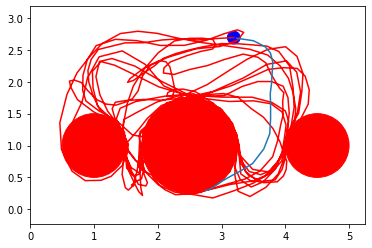

KeyboardInterrupt: 

In [5]:

x0 = np.array([0.1,1.1])
opt_args = {
    'x0' : x0,
    'xf' : np.array([5., 1.0]),
    'xpast' : x0,
    'phik' : get_phik(traj_opt.target_distr.evals, traj_opt.basis)
}
traj = []
traj_opt.solver.solve(args=opt_args)
for _ in range(1000):
    start_time = time.time()
    traj_opt.solver.solve(max_iter=50, args=opt_args)
    end_time = time.time()
    print('elapsed time', end_time-start_time)
    sol = traj_opt.solver.get_solution()
    u = sol['x'][0,2:].copy()
    x0 = robot.f(x0, u)
    traj.append(x0.copy())

    opt_args.update({'x0': x0})
    N = 20
    if len(traj) < 20:
        N = len(traj)

    opt_args.update({'xpast': np.array(random.sample(traj, N))})
    
    traj_opt.solver.solution['x'] = index_update(sol['x'], index[:-1,:], sol['x'][1:,:])
    traj_opt.solver.solution['x'] = index_update(sol['x'], index[-1,:], sol['x'][-1,:])

    clear_output(wait=True)
    plt.contour(X, Y, P)
    _traj = np.array(traj)
    plt.plot(_traj[:,0], _traj[:,1], 'r')
    plt.plot(sol['x'][:,0], sol['x'][:,1])
    circle1 = plt.Circle((2.5,1.0), 0.75, color='r')
    circle2 = plt.Circle((4.5,1.0), 0.5, color='r')
    circle3 = plt.Circle((1.0,1.0), 0.5, color='r')

    rob = plt.Circle((x0[0],x0[1]), 0.1, color='b')

    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().add_patch(circle3)
    plt.gca().add_patch(rob)
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.axis('equal')
    plt.pause(0.001)
    # plt.show()

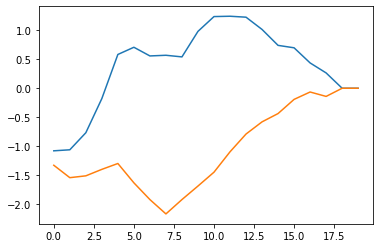

In [6]:
plt.plot(sol['x'][:,2:])